## Computer Vision: Predicting Handwritten digits from the MNIST dataset 

I have created this notebook as a submission to a Kaggle competition called 'Digit Recognizer'. The competition page can be accessed at https://www.kaggle.com/competitions/digit-recognizer/. The following introductory information about the competition and dataset is also available on the competition page. 

MNIST ("Modified National Institute of Standards and Technology") is the de facto “hello world” dataset of computer vision. Since its release in 1999, this classic dataset of handwritten images has served as the basis for benchmarking classification algorithms. As new machine learning techniques emerge, MNIST remains a reliable resource for researchers and learners alike.

In this competition notebook, our goal is to correctly identify digits from a dataset of tens of thousands of handwritten images. We will experiment with different algorithms to learn first-hand what works well and how techniques compare. 

**Dataset Description**

The data files train.csv and test.csv contain gray-scale images of hand-drawn digits, from zero through nine.

Each image is 28 pixels in height and 28 pixels in width, for a total of 784 pixels in total. Each pixel has a single pixel-value associated with it, indicating the lightness or darkness of that pixel, with higher numbers meaning darker. This pixel-value is an integer between 0 and 255, inclusive.

The training data set, (train.csv), has 785 columns. The first column, called "label", is the digit that was drawn by the user. The rest of the columns contain the pixel-values of the associated image. 

The test data set, (test.csv), is the same as the training set, except that it does not contain the "label" column. 

The evaluation metric for this contest is the categorization accuracy, or the proportion of test images that are correctly classified. For example, a categorization accuracy of 0.97 indicates that you have correctly classified all but 3% of the images. 

So, let's get started.

In [378]:
## Importing necessary libraries and files 
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt 
import seaborn as sns 

pd.set_option('display.max_rows', 300) 
pd.set_option('display.max_columns', 75) 
sns.set_style("whitegrid") 

import gc 
gc.collect() 

import warnings
warnings.filterwarnings("ignore")

from sklearn.preprocessing import StandardScaler, RobustScaler 
from sklearn.model_selection import train_test_split 
from sklearn.metrics import classification_report, confusion_matrix

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
# set random seed 
# SEED = np.random.default_rng().integers(999_999) 
SEED = 99 
from tensorflow.keras.utils import set_random_seed 
set_random_seed = SEED 

211176

In [308]:
## creating dataframes  
sample_submission = pd.read_csv('/kaggle/input/digit-recognizer/sample_submission.csv')
train = pd.read_csv('/kaggle/input/digit-recognizer/train.csv')
test = pd.read_csv('/kaggle/input/digit-recognizer/test.csv')
df_names = ['sample_submission', 'train', 'test'] 

In [396]:
## inspecting datasets 
for i, df in enumerate([sample_submission, train, test]): 
    df.name = df_names[i]
    print('----------', df.name, '----------')
    print(df.info(), sep='\n\n') 
#     print(df.head())
#     print(df.describe().T)

# Checking target class/label distribution in training and test sets 
print('\nClass distribution in Training set:', train.label.value_counts(normalize=True).sort_index(), sep='\n') 

---------- sample_submission ----------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28000 entries, 0 to 27999
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   ImageId  28000 non-null  int64
 1   Label    28000 non-null  int64
dtypes: int64(2)
memory usage: 437.6 KB
None
---------- train ----------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42000 entries, 0 to 41999
Columns: 785 entries, label to pixel783
dtypes: int64(785)
memory usage: 251.5 MB
None
---------- test ----------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28000 entries, 0 to 27999
Columns: 784 entries, pixel0 to pixel783
dtypes: int64(784)
memory usage: 167.5 MB
None

Class distribution in Training set:
label
0    0.098381
1    0.111524
2    0.099452
3    0.103595
4    0.096952
5    0.090357
6    0.098500
7    0.104786
8    0.096738
9    0.099714
Name: proportion, dtype: float64


## Fitting a Baseline model: GradientBoostingClassifier 
We will use this simple model which uses tabular data, as a baseline model before we delve into constructing our ConvNet model for further performance improvements. Since the provided image pixel data is already flattened from its original image dimensions of (28,28,1) to dimensions of (784,), it will be quite effortless to fit this classifier on this dataset.

In [379]:
# Normalizing datasets to have values 0 to 1 
X_train_full = train.drop('label', axis=1) / 255 
y_train_full = train[['label']] 
X_test = test / 255 

# Scaling datasets: standardization  
scaler = StandardScaler() 
# scaler = RobustScaler() 

X_train_full[:] = scaler.fit_transform(X_train_full) 
X_test[:] = scaler.transform(X_test)

As we move further, you will notice terms such as training set, validation set, holdout set and test set throughout this notebook. For clarity, training set is that part of the original training dataset on which the model / algorithm is trained to learn patterns. 

The validation set is a portion of the traning set that is internally used by both our models (gradient boosting as well as nerual networks) to prevent over-fitting. In other words, the model trains on the training set, and simultaneously checks if its performance is also improving (or at least not decaying) on the validation set within the specified parameters while fitting the model. 

The holdout set is that part of the original training dataset which we have kept aside before fitting the model. That is, it is only used to evaluate the performance of the fitted model. With this we get to know if the model has indeed generalized well, not just on its internal validation set, but also on the as-yet unseen holdout set. 

The test set is not part of the original training dataset - it is the dataset on which competition will score our model performance. We are only given the features in the test set and the labels are not disclosed to us. The objective of the competion is for participants like us to provide the most accurate predictions on the test set. We get to know the accuracy score only after submission to the competition and our best score is reflected on the competition leaderboard. 

**Methodology** 

We will build 2 models to make predictions in this notebook: 1st model will be using the 1 dimensional flattened pixel data provided in the competition. For this we will use the GradientBoostingClassifer from scikit-learn library. Since this is a relatively simple model (compared to Convolutional neural networks which are most popular for this kind of work), we will take this as a baseline model and see how much improvement we can get from our alternate model which will be a Convolutional Neural Network (CNN) or convnet. Since the competition is being evaluated on the categorical accuracy of the predictions, we will be primarily be relying on this metric to compare model performances. 

Note: In the course of developing this Notebook, I have focused my efforts mainly on the CNN and have tried numerous combinations of parameters when building the model, but have retained here only that combination which has produced the best performance metrics so far. 

In [380]:
# splitting into training and validation (holdout) sets 
SEED = SEED # change from SEED only if experimenting in this cell 
[y_train, y_val, y_test] = [pd.DataFrame() for i in range(3)]
X_train, X_val, y_train['label'], y_val['label'] = train_test_split(X_train_full, y_train_full.label, test_size=0.1, random_state=SEED) 

# modeling 
from sklearn.ensemble import GradientBoostingClassifier 
model = GradientBoostingClassifier(n_estimators=200, subsample = 0.50, max_features = 0.8, n_iter_no_change=3, validation_fraction = 0.30, random_state=SEED, verbose=2) 
model.fit(X_train, y_train) 

      Iter       Train Loss      OOB Improve   Remaining Time 
         1           1.9074           0.3770           22.84m
         2           1.6772           0.2311           22.78m
         3           1.5043           0.1641           22.78m
         4           1.3718           0.1299           22.59m
         5           1.2587           0.1117           22.42m
         6           1.1683           0.0904           22.26m
         7           1.0865           0.0842           22.10m
         8           1.0092           0.0694           21.97m
         9           0.9479           0.0665           21.85m
        10           0.8781           0.0604           21.71m
        11           0.8359           0.0495           21.58m
        12           0.7865           0.0455           21.44m
        13           0.7303           0.0404           21.32m
        14           0.7041           0.0367           21.18m
        15           0.6680           0.0313           21.05m
       

GradientBoostingClassifier(max_features=0.8, n_estimators=200,
                           n_iter_no_change=3, random_state=99, subsample=0.5,
                           validation_fraction=0.3, verbose=2)

Our baseline model trained for 128 epochs (number of iterations) when the early stopping feature kicked in, which means we have found the best parameters (weights) for this model in its present configuration. Let us evaluate how well our model has learnt so far and also draw some visualizations to get an intuition into the quality of its performance. 

In [381]:
## Evaluating model performance 
# fit_scores = pd.DataFrame(dict(train_loss=model.train_score_, oob_improv=model.oob_improvement_), index=range(1, len(model.estimators_)+1))
# print(fit_scores) 

print('random_state:', model.random_state)
print('train set accuracy:', model.score(X_train, y_train) ) 
print('holdout set accuracy:', model.score(X_val, y_val)) 

random_state: 99
train set accuracy: 0.9640740740740741
holdout set accuracy: 0.9426190476190476


In [382]:
# Making Predictions 
y_train['pred'] = model.predict(X_train)
y_val['pred'] = model.predict(X_val) 
y_test['pred'] = model.predict(X_test) 

To get a feel of the quality of predictions, I have also displayed randomly selected images alongwith their values predicted by the baseline GradientBoosting model. 

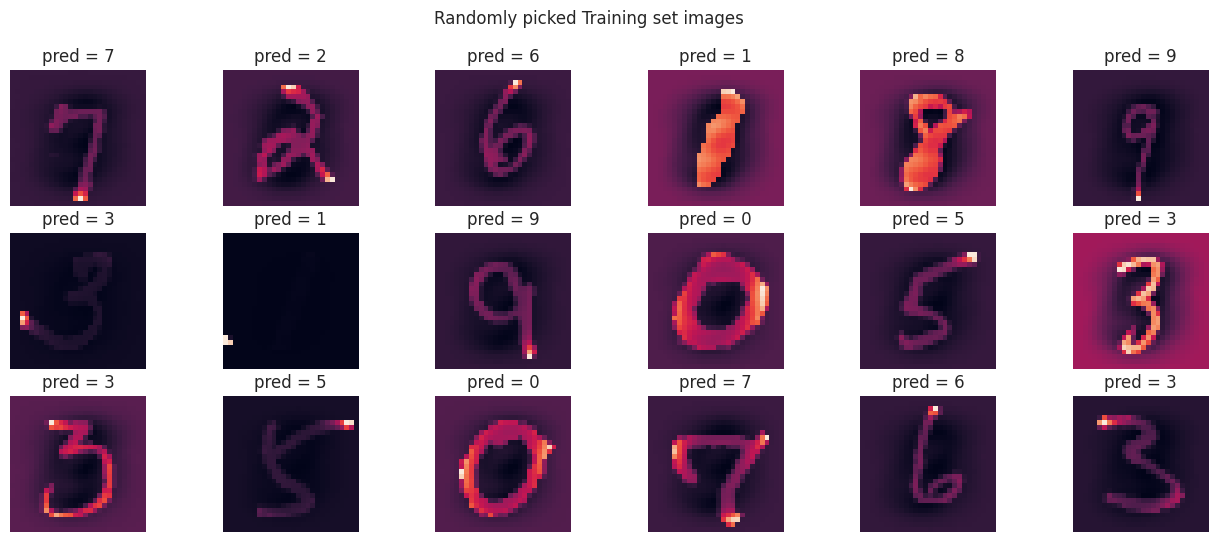

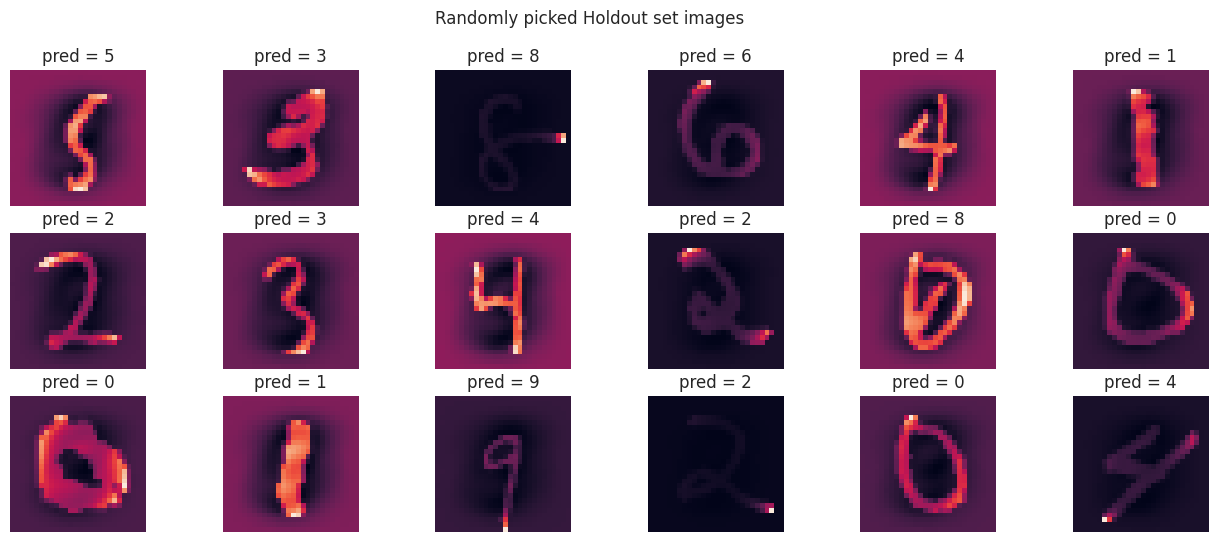

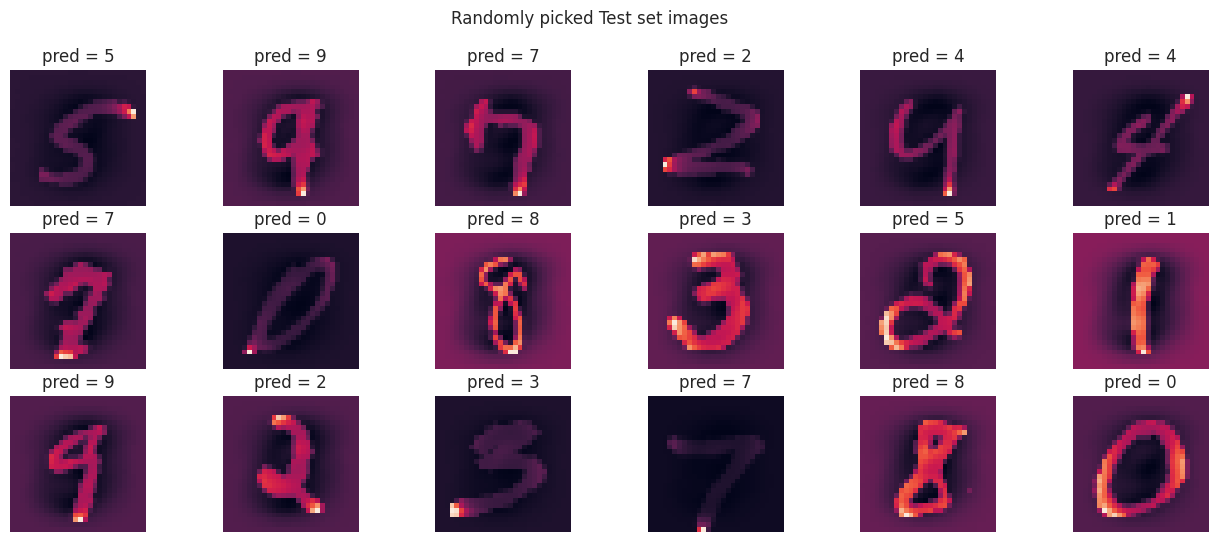

In [319]:
## Visualizing actual images vs model predictions 
# selecting random images indexes for each of training, holdout and test datasets
nos = 18
tr_ixs = np.random.choice(range(X_train.shape[0]), nos, replace=False )
val_ixs = np.random.choice(range(X_val.shape[0]), nos, replace=False )
ts_ixs = np.random.choice(range(X_val.shape[0]), nos, replace=False ) 

# Training set 
fig = plt.figure(figsize=(16, 6))
for i, ix in enumerate(tr_ixs): 
    fig.suptitle('Randomly picked Training set images')
    a = fig.add_subplot(3,6, 1 + i)
    imgplot = plt.imshow(X_train.values.reshape(-1, 28, 28, 1)[ix]) 
    a.axis('off')
    a.set_title('pred = '+ str(y_train.pred.values[ix]) )

# Holdout set 
fig = plt.figure(figsize=(16, 6))
for i, ix in enumerate(val_ixs): 
    fig.suptitle('Randomly picked Holdout set images')
    a = fig.add_subplot(3,6, 1 + i)
    imgplot = plt.imshow(X_val.values.reshape(-1, 28, 28, 1)[ix])  
    a.axis('off')
    a.set_title('pred = '+ str(y_val.pred.values[ix]) )

# Test set 
fig = plt.figure(figsize=(16, 6))
for i, ix in enumerate(ts_ixs): 
    fig.suptitle('Randomly picked Test set images')
    a = fig.add_subplot(3,6, 1 + i)
    imgplot = plt.imshow(X_test.values.reshape(-1, 28, 28, 1)[ix])  
    a.axis('off')
    a.set_title('pred = '+ str(y_test.pred.values[ix]) ) 
    

Let us also have a look at the Confusion Matrix and Classification Report for Training and Holdout sets. We cannot draw these metrics for the test set because we don't have true value labels for the test set. 

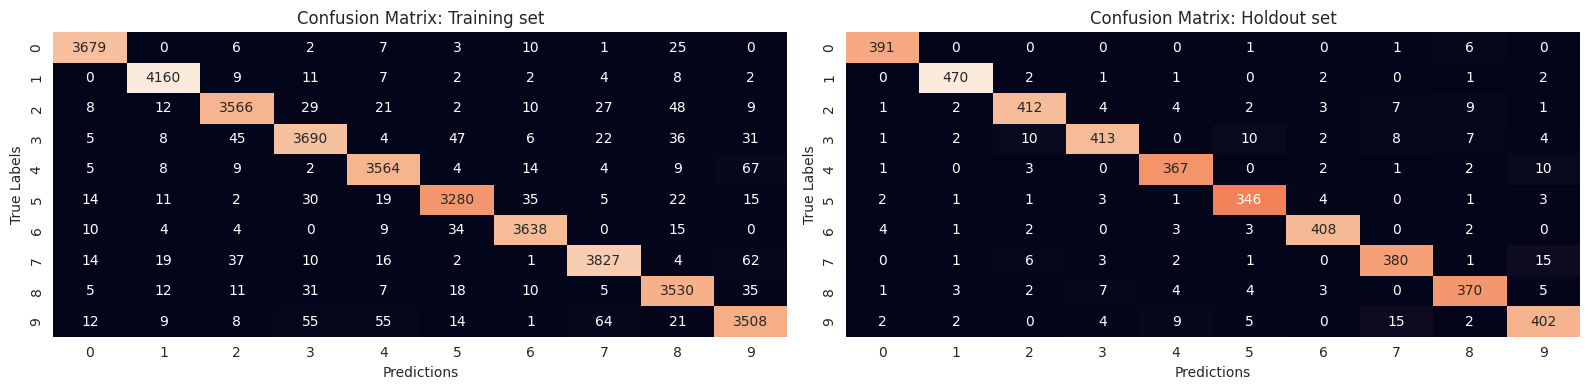

In [383]:
## model evaluation with Confusion Matrix 

cf_params = dict(ylabel='True Labels', xlabel='Predictions')
fig, ax = plt.subplots(1,2, figsize=(16,4))
tr_cf= sns.heatmap(confusion_matrix(y_train.label, y_train.pred), annot=True, fmt='g', cbar=0, ax=ax[0])
tr_cf.set(title='Confusion Matrix: Training set', **cf_params)
ho_cf = sns.heatmap(confusion_matrix(y_val.label, y_val.pred), annot=True, fmt='g', cbar=0, ax=ax[1])
ho_cf.set(title='Confusion Matrix: Holdout set', **cf_params) 
plt.tight_layout() 

In [384]:
## model evaluation with Classification Report 

print('Classification Report: Training set')
print(classification_report(y_train.label, y_train.pred))

print('Classification Report: Holdout set')
print(classification_report(y_val.label, y_val.pred)) 

Classification Report: Training set
              precision    recall  f1-score   support

           0       0.98      0.99      0.98      3733
           1       0.98      0.99      0.98      4205
           2       0.96      0.96      0.96      3732
           3       0.96      0.95      0.95      3894
           4       0.96      0.97      0.96      3686
           5       0.96      0.96      0.96      3433
           6       0.98      0.98      0.98      3714
           7       0.97      0.96      0.96      3992
           8       0.95      0.96      0.96      3664
           9       0.94      0.94      0.94      3747

    accuracy                           0.96     37800
   macro avg       0.96      0.96      0.96     37800
weighted avg       0.96      0.96      0.96     37800

Classification Report: Holdout set
              precision    recall  f1-score   support

           0       0.97      0.98      0.98       399
           1       0.98      0.98      0.98       479
       

In [376]:
## making submission to the competition using model trained on the entire training set 
model = GradientBoostingClassifier(n_estimators=100, subsample = 0.50, max_features = 0.8, n_iter_no_change=3, validation_fraction = 0.3, random_state=SEED, verbose=2) 
model.fit(X_train_full, y_train_full) 

y_test['pred'] = model.predict(X_test) 
submission_gb = pd.DataFrame(dict(ImageId = X_test.index + 1, Label = y_test.pred) )
submission_gb.to_csv('submission_gb.csv', index=False) 
# submission_gb.info()  
# submission_gb.head() 

With the baseline model, we have obtained training, holdout, and test set (i.e. competition submission) accuracy scores of approx. 95%, 94% and 93% respectively. The classification report also shows precision, recall and f1 scores for the holdout set mostly hovering around 94%. 

This isn't too bad for a model that was trained on simple 1D image data. However, it does take some time to fit optimally - like it took more than 8 minutes to fit in the above run. Now let us see if we can improve these scores by developing a Convnet (CNN) model on 2D image data. 

## Fitting alternate model: Convolutional Neural Networks (CNN) 
We will fit a 2DConvnet (CNN) to see if we can improve upon the performance results of the baseline model. In order to fit a 2DConvnet model, we will first reshape the provided flattened image pixel data to its original image dimensions of (28,28,1) for each image record.

In [324]:
from sklearn.metrics import log_loss, accuracy_score 
from tensorflow.keras.models import Sequential  
from tensorflow.keras.layers import InputLayer, Rescaling, RandomFlip, RandomRotation, RandomZoom, RandomTranslation
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, GlobalMaxPooling2D, GlobalAveragePooling2D, BatchNormalization, Dropout, Flatten, Dense 
from tensorflow.keras.optimizers import Adam, SGD 
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau 
gc.collect() 

336639

In [326]:
# Normalizing datasets to have values 0 to 1 
X_train_full = train.drop('label', axis=1) / 255 
y_train_full = train[['label']] 
X_test = test / 255 

# reshape pixel data to original image dimensions of (height, width, channels)=(28,28,1) 
print('Original train and test shapes: ', X_train_full.shape, X_test.shape)
X_train_full = X_train_full.values.reshape(-1, 28, 28, 1) 
X_test = X_test.values.reshape(-1, 28, 28, 1) 
print('After reshaping:\ntrain and test shapes: ', X_train_full.shape, X_test.shape)

Original train and test shapes:  (42000, 784) (28000, 784)
After reshaping:
train and test shapes:  (42000, 28, 28, 1) (28000, 28, 28, 1)


In [367]:
# splitting into training and validation (holdout) sets 
SEED = SEED # change from SEED only if experimenting in this cell 
from sklearn.model_selection import train_test_split 
[y_train, y_val, y_test] = [pd.DataFrame() for i in range(3)]
X_train, X_val, y_train['label'], y_val['label'] = train_test_split(X_train_full, y_train_full.label, test_size=0.1, random_state=SEED)

In [368]:
# modeling 
def create_model(): 
    model = Sequential() 
    model.add(InputLayer(input_shape=(28,28,1) ) )

    # adding image augmentation layers 
    model.add(RandomRotation(factor=0.12) ) # Randomly rotate images by given % of a circle 
    model.add(RandomZoom(height_factor=0.2, width_factor=0.2) ) # Randomly zoom into or out of images by up to 20% 
    model.add(RandomTranslation(height_factor=0.1, width_factor=0.1) ) # Randomly shift images by up to 10% of height and width 
    
    # adding Convolution layers 
    for i in range(1,4): 
        model.add(BatchNormalization() )
        model.add(Conv2D(filters=i*32, kernel_size=(3,3), padding='same', activation='relu') ) 
        model.add(Conv2D(filters=i*32, kernel_size=(3,3), padding='same', activation='relu') ) 
        model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
        model.add(Dropout(0.2)) 
        
    # adding fully connected & output layers 
    model.add(Flatten() ) 
    model.add(Dense(units=model.layers[-1].output.shape[1], activation='relu')) 
    model.add(Dense(units=10, activation='softmax')) 
    
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy']) 
    print(model.summary()) 
    return model 

cnn = create_model() 

Model: "sequential_25"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ random_rotation_24              │ (None, 28, 28, 1)      │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_zoom_24 (RandomZoom)     │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_translation_24           │ (None, 28, 28, 1)      │             0 │
│ (RandomTranslation)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_79          │ (None, 28, 28, 1)      │             4 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_129 (Conv2D)             │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_130 (Conv2D)             │ (None, 28, 28, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_79 (MaxPooling2D) │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_78 (Dropout)            │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_80          │ (None, 14, 14, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_131 (Conv2D)             │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_132 (Conv2D)             │ (None, 14, 14, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_80 (MaxPooling2D) │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_79 (Dropout)            │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_81          │ (None, 7, 7, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_133 (Conv2D)             │ (None, 7, 7, 96)       │        55,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_134 (Conv2D)             │ (None, 7, 7, 96)       │        83,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_81 (MaxPooling2D) │ (None, 3, 3, 96)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_80 (Dropout)            │ (None, 3, 3, 96)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_22 (Flatten)            │ (None, 864)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 864)            │       747,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 10)             │         8,650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 959,822 (3.66 MB)

 Trainable params: 959,628 (3.66 MB)

 Non-trainable params: 194 (776.00 B)

None


In [369]:
gc.collect() 

# defining fitting parameters 
monitor = 'val_accuracy' # ['val_accuracy', 'val_loss']
epochs, batch_size = 3, 64    

# defining callbacks to adapt model during fitting 
early_stop = EarlyStopping(monitor=monitor, patience=8, restore_best_weights=True, verbose=1) 
rlrop = ReduceLROnPlateau(monitor=monitor, patience=4, verbose=1) 

# fitting model 
history = cnn.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, callbacks=[early_stop, rlrop], verbose=1, validation_split=0.3, shuffle=True) 

Epoch 1/3
414/414 ━━━━━━━━━━━━━━━━━━━━ 81s 185ms/step - accuracy: 0.6615 - loss: 1.0199 - val_accuracy: 0.9547 - val_loss: 0.1440 - learning_rate: 0.0010
Epoch 2/3
414/414 ━━━━━━━━━━━━━━━━━━━━ 81s 182ms/step - accuracy: 0.9421 - loss: 0.1883 - val_accuracy: 0.9787 - val_loss: 0.0744 - learning_rate: 0.0010
Epoch 3/3
414/414 ━━━━━━━━━━━━━━━━━━━━ 76s 183ms/step - accuracy: 0.9594 - loss: 0.1315 - val_accuracy: 0.9802 - val_loss: 0.0710 - learning_rate: 0.0010
Restoring model weights from the end of the best epoch: 3.


The model has completed training and with as few as only 3 epochs, is showing a validation set accuracy of more than 98%. That looks impressive. Let us calculate other evaluation metrics and also run some visualizations to delve deeper.

In [370]:
## Evaluating model performance 

tr_scores = cnn.evaluate(X_train, y_train.label)
val_scores = cnn.evaluate(X_val, y_val.label)
print('random_state:', model.random_state)
print('train set accuracy:', tr_scores[1]) 
print('holdout set accuracy:', val_scores[1]) 

1182/1182 ━━━━━━━━━━━━━━━━━━━━ 30s 26ms/step - accuracy: 0.9834 - loss: 0.0587
132/132 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.9811 - loss: 0.0728
random_state: 99
train set accuracy: 0.9825661182403564
holdout set accuracy: 0.9838095307350159


<Axes: title={'center': 'Training vs Validation Log Loss observed during model fitting'}, xlabel='epochs'>

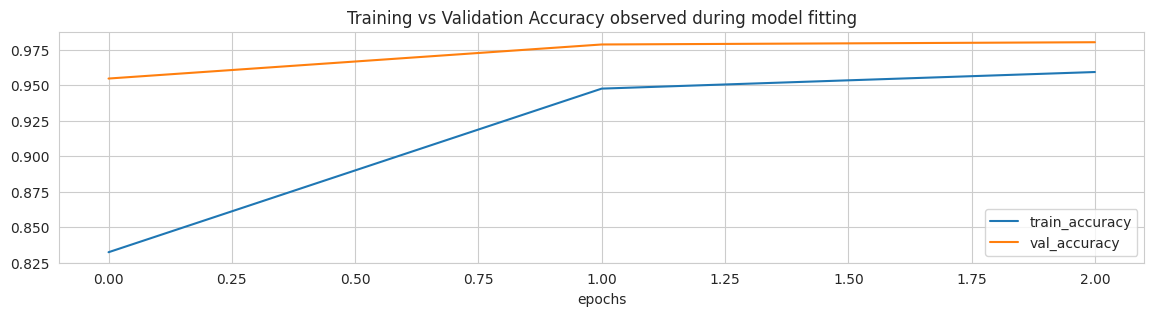

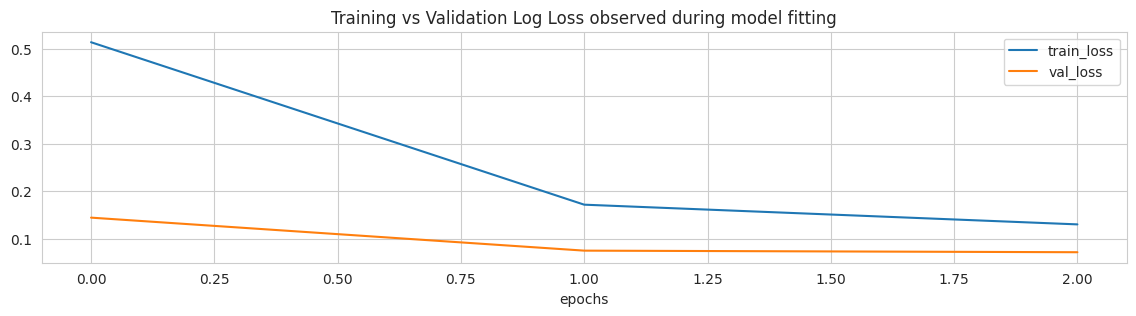

In [371]:
## Visualizing model performance 
plot_params = dict(xlabel='epochs', figsize=(14, 3))
history_df = pd.DataFrame(history.history) 
history_df.rename(columns=dict(loss='train_loss', accuracy='train_accuracy'), inplace=True)
history_df[['train_accuracy', 'val_accuracy']].plot(title='Training vs Validation Accuracy observed during model fitting', **plot_params) 
history_df[['train_loss', 'val_loss']].plot(title='Training vs Validation Log Loss observed during model fitting', **plot_params) 

In [372]:
## Making preidctions 
y_train['pred'] = cnn.predict(X_train).argmax(axis=1) 
y_val['pred'] = cnn.predict(X_val).argmax(axis=1) 
y_test['pred'] = cnn.predict(X_test).argmax(axis=1) 


1182/1182 ━━━━━━━━━━━━━━━━━━━━ 30s 25ms/step
132/132 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step
875/875 ━━━━━━━━━━━━━━━━━━━━ 22s 25ms/step


Just like we did for the baseline model, let us also look up randomly selected images from the training, holdout and test datasets, alongwith their respective values predicted by our CNN model, to see for real how well our digit classification model is performing.

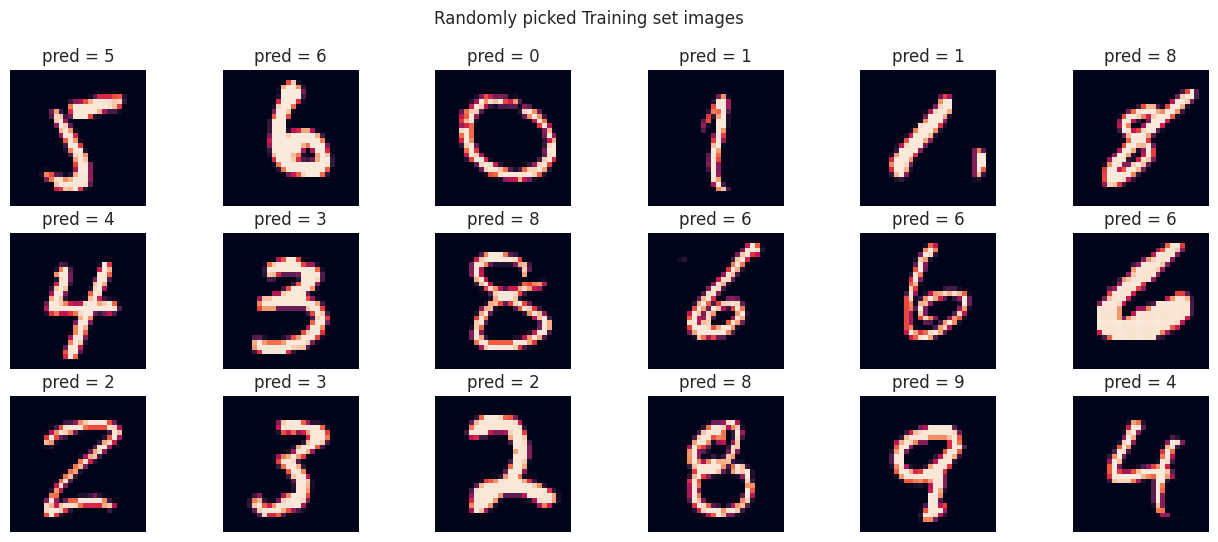

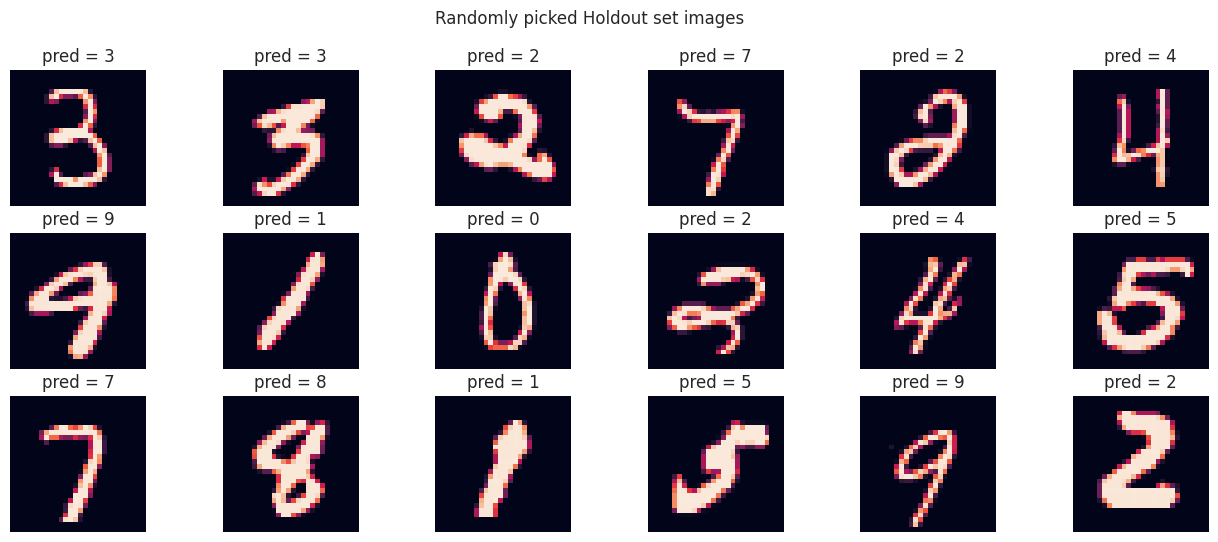

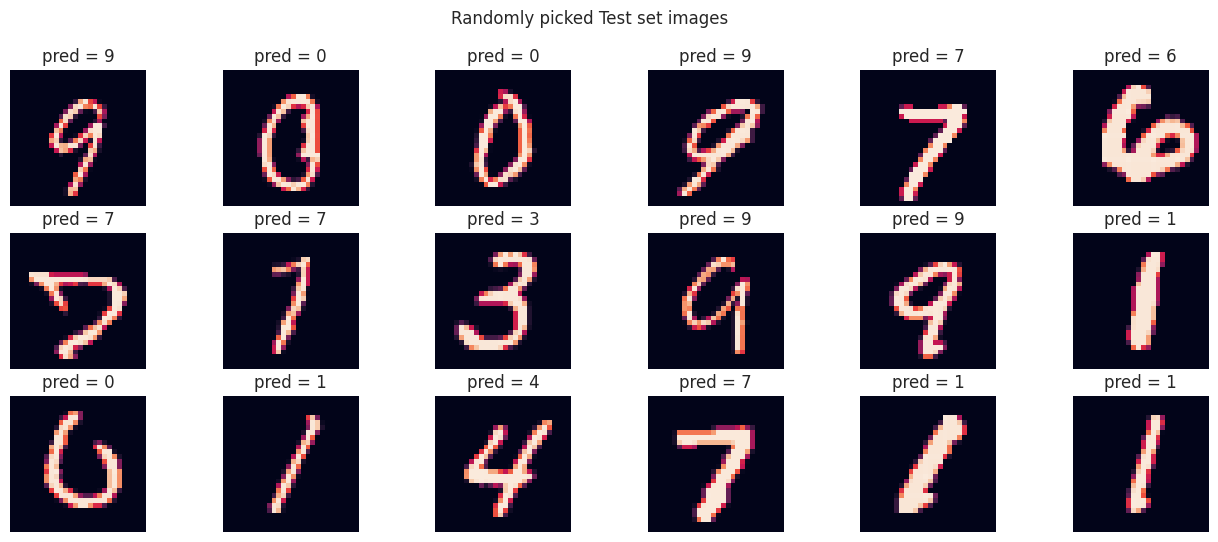

In [373]:
## Visualizing actual images vs model predictions 
# selecting random images indexes for each of training, holdout and test datasets
nos = 18
tr_ixs = np.random.choice(range(X_train.shape[0]), nos, replace=False )
val_ixs = np.random.choice(range(X_val.shape[0]), nos, replace=False )
ts_ixs = np.random.choice(range(X_val.shape[0]), nos, replace=False ) 

# Training set 
fig = plt.figure(figsize=(16, 6))
for i, ix in enumerate(tr_ixs): 
    fig.suptitle('Randomly picked Training set images')
    a = fig.add_subplot(3,6, 1 + i)
    imgplot = plt.imshow(X_train[ix]) 
    a.axis('off')
    a.set_title('pred = '+ str(y_train.pred.values[ix]) )

# Holdout set 
fig = plt.figure(figsize=(16, 6))
for i, ix in enumerate(val_ixs): 
    fig.suptitle('Randomly picked Holdout set images')
    a = fig.add_subplot(3,6, 1 + i)
    imgplot = plt.imshow(X_val[ix]) 
    a.axis('off')
    a.set_title('pred = '+ str(y_val.pred.values[ix]) )

# Test set 
fig = plt.figure(figsize=(16, 6))
for i, ix in enumerate(ts_ixs): 
    fig.suptitle('Randomly picked Test set images')
    a = fig.add_subplot(3,6, 1 + i)
    imgplot = plt.imshow(X_test[ix]) 
    a.axis('off')
    a.set_title('pred = '+ str(y_test.pred.values[ix]) )


Quite satisfactorily, the predicted labeling appears on the mark in all the above instances - something that was true for our baseline model as well, although when considering the overall dataset, it is lagging far behind our CNN model.

Let us also have a look at the Confusion Matrix and Classification Report for Training and Holdout sets. We cannot draw these metrics for the test set because we don't have true value labels for the test set. 

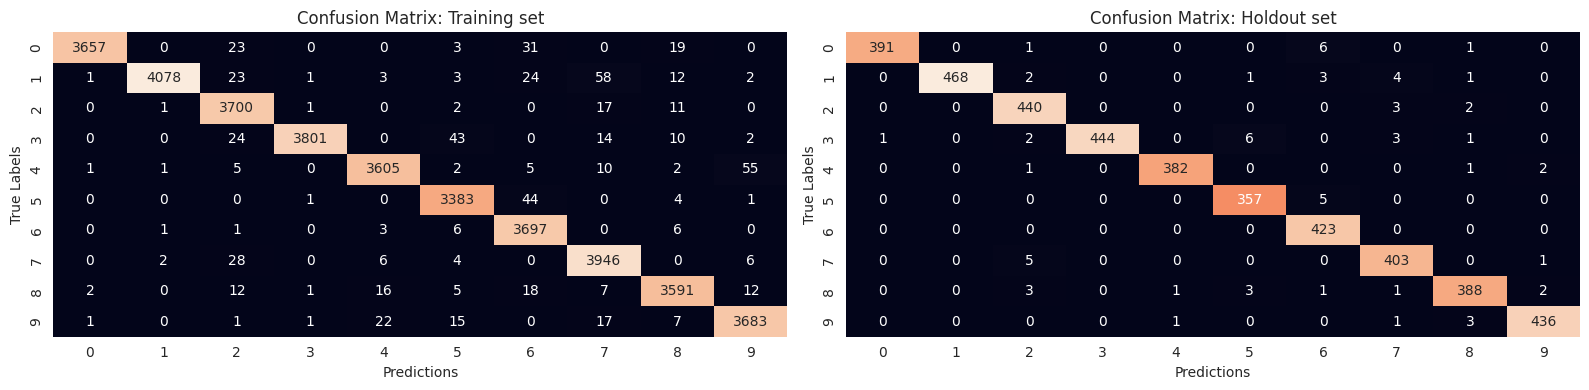

In [374]:
## model evaluation with Confusion Matrix 

cf_params = dict(ylabel='True Labels', xlabel='Predictions')
fig, ax = plt.subplots(1,2, figsize=(16,4))
tr_cf= sns.heatmap(confusion_matrix(y_train.label, y_train.pred), annot=True, fmt='g', cbar=0, ax=ax[0])
tr_cf.set(title='Confusion Matrix: Training set', **cf_params)
ho_cf = sns.heatmap(confusion_matrix(y_val.label, y_val.pred), annot=True, fmt='g', cbar=0, ax=ax[1])
ho_cf.set(title='Confusion Matrix: Holdout set', **cf_params) 
plt.tight_layout()

In [375]:
## model evaluation with Classification Report 

print('Classification Report: Training set')
print(classification_report(y_train.label, y_train.pred))

print('Classification Report: Holdout set')
print(classification_report(y_val.label, y_val.pred))

Classification Report: Training set
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      3733
           1       1.00      0.97      0.98      4205
           2       0.97      0.99      0.98      3732
           3       1.00      0.98      0.99      3894
           4       0.99      0.98      0.98      3686
           5       0.98      0.99      0.98      3433
           6       0.97      1.00      0.98      3714
           7       0.97      0.99      0.98      3992
           8       0.98      0.98      0.98      3664
           9       0.98      0.98      0.98      3747

    accuracy                           0.98     37800
   macro avg       0.98      0.98      0.98     37800
weighted avg       0.98      0.98      0.98     37800

Classification Report: Holdout set
              precision    recall  f1-score   support

           0       1.00      0.98      0.99       399
           1       1.00      0.98      0.99       479
       

The reports show almost similar scores hovering around 98% for all digits but it seems maximum mistakes are being made in recognizing handwritten digits 2, 7, 5, and 8. Perhaps, we can address this with more iterations, data augmentation, and further tuning the hyper parameters. 

That said, the overall accuracy of more than 98% with only 3 iterations of the CNN model is a very significant improvement over our baseline model that had an accuracy score of about 94% after more than 125 iterations. This model also gave a competition test set accuracy score of 98.796% on the leaderboard. 

The CNN model performance looks satisfactory so far. So, I will stop here since my objective of creating a working CNN model that gives a reasonable prediction performance has been achieved. 

Thanks for your time reading this work.

In [399]:
## making submission to the competition on the test set 
# y_test['pred'] = cnn.predict(X_test).argmax(axis=1)
# y_test = pd.DataFrame(y_test)
# y_test['pred']=y_test.idxmax(axis=1)
submission_cnn = pd.DataFrame(dict(ImageId = X_test.index + 1, Label = y_test.pred) )
submission_cnn.to_csv('submission_cnn.csv', index=False) 
submission_cnn.info()  
submission_cnn 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28000 entries, 0 to 27999
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   ImageId  28000 non-null  int64
 1   Label    28000 non-null  int64
dtypes: int64(2)
memory usage: 437.6 KB


,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,7
4,5,2
...,...,...
27995,27996,9
27996,27997,7
27997,27998,3
27998,27999,9
